# Fixed Income Derivatives Practice Problems and Notes

In [192]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import numpy as np
from Binomial_Fixed.ficcvol import *
from Binomial_Fixed.binomial import *
from Binomial_Fixed.ratecurves import *
import scipy
from scipy.optimize import fsolve
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
from Binomial_Fixed.treasury_cmds import *

It is July 30, 2015. The cheapest-to-deliver bond in a September 2015 Treasury bond futures contract is a 13% coupon bond, and delivery is expected to be made on September 30, 2015. Coupon payments on the bond are made on February 4 and August 4 each year. The term structure is flat, and the rate of interest with semiannual compounding is 12% per annum. The conversion factor for the bond is 1.5. The current quoted bond price is $110. Calculate the quoted futures price for the contract. Explain.

In [140]:
def convert_dt(date):
    if type(date) != str:
        return date
    else:

        return pd.to_datetime(date)

In [141]:
(convert_dt("2015-01-01")-convert_dt("2014-08-15")).days

139

In [142]:
p0 = 110
conversion = 1.5
repo = 2*np.log(1.06)
cpn = .13/2
date_0 = dt.date(2015,7,30)
cpdate = dt.date(2015,2,4)
cpdate1 = dt.date(2015,8,4)
delivery_dt = dt.date(2015,9,30)
period  = (cpdate1-cpdate).days
accint = ((date_0-cpdate).days/period)*(cpn)*100
cash_price =p0+accint
cash_price
cpdate1-date_0

def futures_price(clean_price, repo,cpn,curr_date, cpn_date0,cpn_date1,conversion,delivery_date):
    curr_date = convert_dt(curr_date)
    cpn_date0 = convert_dt(cpn_date0)
    cpn_date1 = convert_dt(cpn_date1)
    if cpn >.90:
        cpn = cpn*(1/100)
    else:
        cpn = cpn
    delivery_date = convert_dt(delivery_date)
    accint = ((curr_date-cpn_date0).days/(cpn_date1-cpn_date0).days)*(cpn*100)
    dirty_price = clean_price+accint
    I = cpn*100*(np.exp(-repo*(cpn_date1-curr_date).days/365))
    DTD = (delivery_date-curr_date).days/(365)
    discount = np.exp(repo*DTD)
    accrued_int = 100*cpn*((delivery_date-cpn_date1).days/((cpn_date1+pd.DateOffset(months = 6))-cpn_date1).days)
    F0 = (dirty_price-I)*discount - accrued_int

    return F0/conversion

def forward_price(clean_price, repo,cpn,curr_date,days_accrued,cpn_date1,delivery_date):
    curr_date = convert_dt(curr_date)
    cpn_date0 = curr_date - dt.timedelta(days = days_accrued)
    cpn_date1 = convert_dt(cpn_date1)
    delivery_date = convert_dt(delivery_date)

    repo = repo/100
    cpn = cpn*(1/2)

    accint = ((curr_date-cpn_date0).days/(cpn_date1-cpn_date0).days)*(cpn)
    dirty_price = clean_price+accint 

    I = cpn*(np.exp(-repo*(cpn_date1-curr_date).days/360))
    DTD = (delivery_date-curr_date).days/(360)
    discount = np.exp(repo*DTD)
    accrued_int = cpn*((delivery_date-cpn_date1).days/((cpn_date1+pd.DateOffset(months = 6))-cpn_date1).days)
    F0 = (dirty_price-cpn)*discount - accrued_int

    return F0





In [144]:
future_bonds = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/fut_bond_data_FVU3_2023-04-21.xlsx'
bdt_path = 'C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023/data/bdt_params_freq52_2023-04-21.xlsx'
future_description = pd.read_excel(future_bonds, sheet_name='future')
bond_info = pd.read_excel(future_bonds,sheet_name='bonds')
bdt_params = pd.read_excel(bdt_path)
Future_Price = future_description.iloc[1,1]


In [145]:
future_description

,field,FVU3 Comdty
0,last_update_dt,2023-04-21 00:00:00
1,px_last,109.789062
2,last_tradeable_dt,2023-09-29 00:00:00
3,fut_dlv_dt_last,2023-10-04 00:00:00
4,fut_days_expire,159
5,fut_ctd,T 3.875 11/30/27
6,fut_ctd_px,100.757812
7,fut_ctd_gross_basis,-17.074348
8,fut_ctd_net_basis,1.199828


In [146]:
DATE = '2023-04-21'
FUT_DAYS_EXPIRE = 159

In [147]:
Future_Expiration = convert_dt(DATE) +dt.timedelta(159)

In [148]:
bond_info

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


In [149]:
fwd_price = bond_info.apply(lambda row:forward_price(clean_price=row['px_last'],repo = row['repo_reporate'],cpn = row['cpn'],curr_date=DATE,days_accrued=row['days_acc'],cpn_date1=row['nxt_cpn_dt'],delivery_date=Future_Expiration), axis = 1)

In [150]:
conversions = bond_info['conversion']

fwd_price - conversions*Future_Price


0   -0.055717
1    0.082618
2    0.347607
3    0.547646
4    0.757572
dtype: float64

In [151]:
Future_0 = futures_price(110,repo=repo,cpn = cpn,curr_date="2015-07-30",cpn_date0="2015-02-04",cpn_date1="2015-08-04",conversion=1.5,delivery_date="2015-09-30")

## 1.1 Cap Prices

For each cap maturity, $.5\le T \le 10$, use the flat volatility to get the price of the cap.

Report the cap prices across expirations, $.5\le T \le 10$.

Plot the cap prices across expirations.

In [152]:
cap_curves = pd.read_excel('C:/Users/dcste/OneDrive/Fixed_Income_Derivatives/finm-fiderivs-2023\data\cap_curves_2023-03-31.xlsx')
capcurves = cap_curves.copy().set_index('tenor')

In [153]:
def CAP_Floor(spot_rate, strike_rate, volatility,discount,T,dt = .25,N = 1, caplet = True):
    """
    spot_rate : set equal to the forward rate
    strike_rate: set equal to the swap rate
    volatility: flat vol
    discount = discount factor
    T = time to maturity
    dt:  frequency of payments
    N: Notional Value
    """
    d1 = (np.log(spot_rate/strike_rate) + (volatility**2/2)*T)/(volatility*np.sqrt(T))
    d2 = d1 - volatility*np.sqrt(T)
    if caplet == True:
        return N*dt*(discount*(spot_rate*norm.cdf(d1) - strike_rate*norm.cdf(d2)))
    if not caplet:
        return N*dt(discount*(strike_rate*norm.cdf(-d2) - spot_rate*norm.cdf(-d1)))

In [154]:
cap_curves.head(2)

,tenor,swap rates,discounts,forwards,flat vols
0,0.25,0.049149,0.987862,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491


In [155]:
for i in range(1, len(cap_curves)):
    price = 0
    for j in range(1,i+1):
        price +=CAP_Floor(spot_rate=cap_curves.loc[j,'forwards'],strike_rate=cap_curves.loc[i,'swap rates'],volatility=cap_curves.loc[i,'flat vols'],\
                                                       discount=cap_curves.loc[j,'discounts'],T = cap_curves.loc[j,'tenor'] - .25,dt = 0.25,N = 100, caplet = True)
        cap_curves.loc[i,'CAP'] = price




## 1.2 Caplet Prices and Forward Volatilities

Using the cap prices, strip out the
* caplet prices
* forward volatility at $\tau$ which properly prices caplet $\tau$ using Black's formula.

List and plot the forward volatility versus the flat volatiltiy.

In [156]:

cap_curves['CAPLET'] = cap_curves['CAP'].diff()
cap_curves.loc[1,'CAPLET'] = cap_curves.loc[1,'CAP']
cap_curves.head()

,tenor,swap rates,discounts,forwards,flat vols,CAP,CAPLET
0,0.25,0.049149,0.987862,NaN,NaN,NaN,NaN
1,0.50,0.049097,0.975896,0.049045,0.219491,0.051758,0.051758
2,0.75,0.048306,0.964628,0.046724,0.303075,0.160980,0.109222
3,1.00,0.047170,0.954188,0.043764,0.369483,0.324507,0.163527
4,1.25,0.045246,0.945312,0.037559,0.420688,0.523376,0.198868


In [157]:
for i in range(1,len(cap_curves)):
    vol_wrapper = lambda sigma: cap_curves.loc[i,'CAPLET']- CAP_Floor(spot_rate=cap_curves.loc[i,'forwards'],strike_rate=cap_curves.loc[i,'swap rates'],volatility=sigma,discount = cap_curves.loc[i,'discounts'],T = cap_curves.loc[i,'tenor']-.25, dt = .25,N = 100, caplet = True)

    cap_curves.loc[i,'Forward_Vol'] = fsolve(vol_wrapper,.2)

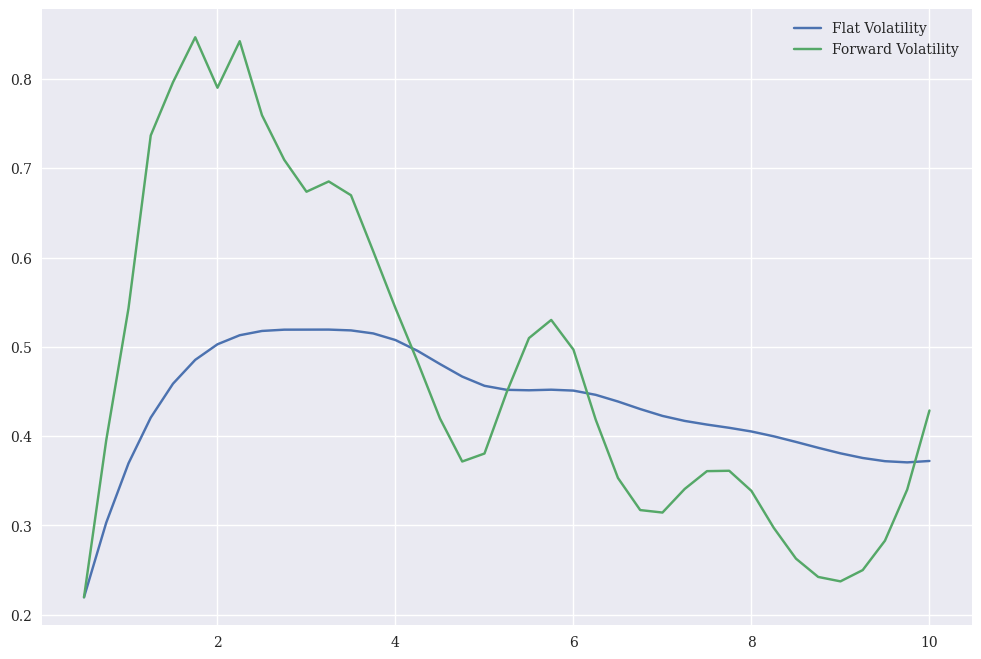

In [158]:
plt.figure(figsize=(12,8))
plt.plot(cap_curves.tenor, cap_curves['flat vols'],label = 'Flat Volatility')
plt.plot(cap_curves.tenor, cap_curves['Forward_Vol'], label = "Forward Volatility")
plt.legend(loc = 0)

## 2.1 Calibrate a BDT model 

Use data from the file `data/cap_curves_2023-03-31.xlsx` to calibrate the model.
* Use the forward volatilities calculated in 1.2 to calibrate $\sigma$ at each step. 
    * If you could not solve 1.2, then use $\sigma=.35$ at every step.
    * You do not have a forward volatility at $\tau=.25$ given there is no caplet there. For purposes of the BDT model, assume $\sigma_{.25}$ is equal to the forward volatility at the first estimated period, $t=0.50$. That is, use the first estimated forward vol (corresponding to $\tau=.50$ for both $t=.25$ and $t=.50$ in the BDT tree.
    
* Given these $\sigma$ parameters, calibrate the series of $\theta$ to fit the zero-coupon bond prices given by `discounts` (multiplied by 100).

Display the series of $\theta$ parameters.

Display the tree of rates from $0\le t \le 10$.

In [159]:
\
capcurves = cap_curves.copy()
capcurves.loc[0,'Forward_Vol'] = capcurves.loc[1,'Forward_Vol']
capcurves.set_index('tenor',inplace=True)
capcurves.head(10)

,swap rates,discounts,forwards,flat vols,CAP,CAPLET,Forward_Vol
tenor,,,,,,,
0.25,0.049149,0.987862,NaN,NaN,NaN,NaN,0.219491
0.50,0.049097,0.975896,0.049045,0.219491,0.051758,0.051758,0.219491
0.75,0.048306,0.964628,0.046724,0.303075,0.160980,0.109222,0.395405
1.00,0.047170,0.954188,0.043764,0.369483,0.324507,0.163527,0.543084
1.25,0.045246,0.945312,0.037559,0.420688,0.523376,0.198868,0.736688
1.50,0.043510,0.937149,0.034841,0.458664,0.746453,0.223077,0.796268
1.75,0.041853,0.929729,0.031925,0.485385,0.980927,0.234474,0.846632
2.00,0.040610,0.922368,0.031920,0.502824,1.222176,0.241250,0.790121
2.25,0.039260,0.915849,0.028476,0.512955,1.457572,0.235396,0.842264


In [160]:
quotes = capcurves['discounts']*100
fwd_vols = capcurves['Forward_Vol']

In [161]:
theta, ratetree = estimate_theta(sigmas=fwd_vols,quotes_zeros=quotes)

In [162]:
format_bintree(theta.to_frame().T,style = '{:.4%}')

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75,4.00,4.25,4.50,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00,7.25,7.50,7.75,8.00,8.25,8.50,8.75,9.00,9.25,9.50,9.75
theta,,-3.2170%,-43.7049%,-68.9707%,-132.5589%,-104.5720%,-111.5430%,-58.3561%,-107.9421%,-31.3650%,-23.6334%,-10.7087%,-27.5366%,-11.1666%,23.3094%,27.8013%,26.3772%,59.4943%,94.9435%,84.4186%,53.5633%,38.8525%,36.4361%,45.0661%,62.1223%,72.6859%,75.9396%,72.0793%,62.4351%,55.8425%,53.6732%,56.0937%,61.8060%,64.6028%,63.9110%,59.8763%,52.3014%,40.8619%,24.9383%,3.2489%


## 2.2 Price the Freddie Mac Bond

The U.S. has many forms of *agency* debt in addition to *Treasury* debt. The largest of these *agency* issuers are the housing entities commonly referred to as Freddie Mac and Fannie Mae. While technically distinct from the U.S. Treasury, they are widely seen as having the full credit and backing of the Treasury--particularly after the bailouts of 2008.

Thus, we will examine this agency debt as (credit) risk-free, just like Treasury debt.

Consider the Freddie Mac bond with Bloomberg ID `BX8543742`.
* Issued 2022-07-26
* Matures 2030-07-26
* Semiannual coupons
* Coupon rate 4.375%
* Issued 25mm.

Price this bond using the model calibrated from 2023-03-31 data.
* We will model this bond as maturing 2030-06-30 (a few weeks early) so that it has maturity of 7.25 years, modeled at quarterly intervals.
* Note that the coupons are paid in the final period and every other quarter prior (semiannually.) Thus, it pays a coupon in after just one quarter from the current time.

The market quote as of 2023-03-31 is \$97.478.

Use the BDT model to price the bond. How close is it to the market quote?

In [163]:
T = 7.25
coupon_freq = 2
dt = .25
compound = int(1/dt)
Tsteps = int(T/dt)
cpn = 0.04375
strike = 100
FACE = 100


In [164]:
payoff_freddie_mac = lambda r: payoff_bond(r, dt = dt, facevalue=FACE*(1+cpn/coupon_freq))
cftree = construct_bond_cftree(T, compound, cpn)

In [165]:
bondtree = bintree_pricing(payoff=payoff_freddie_mac,ratetree=ratetree.iloc[:Tsteps,:Tsteps],cftree=cftree)
bondtree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,107.978713,103.764913,96.630611,90.830086,82.000912,74.413788,63.983307,55.255210,44.355604,35.825077,...,0.595960,0.029850,0.146865,0.000363,0.008632,4.419247e-08,0.000024,1.359190e-15,3.221649e-10,2.406769e-12
1,NaN,114.846037,109.349022,105.306773,98.271220,92.387003,83.384966,75.612420,65.004249,55.904362,...,0.860557,0.091265,0.252328,0.003082,0.025698,4.015793e-06,0.000231,1.232863e-11,2.790436e-08,1.167171e-09
2,NaN,NaN,118.475030,116.000290,110.743411,106.844219,99.915011,94.186410,85.378345,77.643970,...,2.129557,0.531433,0.586970,0.038925,0.110755,4.669927e-04,0.004597,1.744373e-07,1.057834e-05,4.373200e-06
3,NaN,NaN,NaN,122.849643,118.937031,116.678516,111.651909,108.080444,101.571658,96.229846,...,8.249618,3.824891,2.382402,0.645303,0.516003,4.162575e-02,0.064857,9.134617e-04,2.159058e-03,5.352807e-03
4,NaN,NaN,NaN,NaN,123.649186,122.463393,118.756649,116.801342,112.175900,109.059674,...,25.639755,16.837123,11.512722,6.113014,3.819588,1.455201e+00,0.952713,2.858638e-01,2.900512e-01,9.123996e-01


In [166]:

acinntree = construct_accint(timenodes=bondtree.columns,freq = compound,cpn =cpn, cpn_freq=coupon_freq)
clean_tree = np.maximum(bondtree - acinntree,0)
clean_tree.head()

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,106.884963,101.577413,95.536861,88.642586,80.907162,72.226288,62.889557,53.067710,43.261854,33.637577,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,NaN,112.658537,108.255272,103.119273,97.177470,90.199503,82.291216,73.424920,63.910499,53.716862,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,NaN,NaN,117.381280,113.812790,109.649661,104.656719,98.821261,91.998910,84.284595,75.456470,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,120.662143,117.843281,114.491016,110.558159,105.892944,100.477908,94.042346,...,6.062118,2.731141,0.194902,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,122.555436,120.275893,117.662899,114.613842,111.082150,106.872174,...,23.452255,15.743373,9.325222,5.019264,1.632088,0.361451,0.0,0.0,0.0,0.0


In [167]:
payoff_callable = lambda p: np.maximum(p - strike,0)
optiontree = bintree_pricing(payoff=payoff_callable,ratetree=ratetree.iloc[:Tsteps,:Tsteps],undertree=clean_tree, style='american')
optiontree

time,0.00,0.25,0.50,0.75,1.00,1.25,1.50,1.75,2.00,2.25,...,4.75,5.00,5.25,5.50,5.75,6.00,6.25,6.50,6.75,7.00
state,,,,,,,,,,,,,,,,,,,,,
0,11.716547,9.255937,7.021568,5.113205,3.543357,2.325681,1.432885,0.821523,0.433508,0.205833,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,14.465085,11.742282,9.138886,6.851201,4.881980,3.309603,2.109214,1.257478,0.690681,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,NaN,NaN,17.503648,14.625842,11.667490,9.007876,6.607652,4.630210,3.059497,1.892751,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,NaN,NaN,NaN,20.662143,17.843281,14.541600,11.598088,8.746248,6.346053,4.337944,...,0.000013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,NaN,NaN,NaN,NaN,22.555436,20.275893,17.662899,14.613842,11.305188,8.488253,...,0.001518,0.000038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,NaN,NaN,NaN,NaN,NaN,23.277564,21.416979,19.326416,16.970461,14.236159,...,0.022944,0.003668,0.000102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,NaN,NaN,NaN,NaN,NaN,NaN,23.281033,21.692821,19.969344,18.053640,...,0.162821,0.046544,0.008243,0.000244,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.843975,21.436127,19.933267,...,0.741987,0.291918,0.090134,0.017588,0.000547,0.000000,0.000000,0.000000,0.000000,0.000000
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.159259,20.859721,...,2.414127,1.218288,0.508527,0.169224,0.036467,0.001177,0.000000,0.000000,0.000000,0.000000


In [168]:
C_0price = clean_tree.iloc[0,0] - optiontree.iloc[0,0]
quote = 97.478
num_accrued = int((T*compound) %coupon_freq)

numaccrued = int((T*compound)%coupon_freq)
dirty_quote = quote + numaccrued*(cpn/coupon_freq)*FACE
model_dirty = C_0price + acinntree.iloc[0]
pd.DataFrame({'Modeled_Prices':[C_0price,model_dirty],'Market_Prices':[quote,dirty_quote]})

,Modeled_Prices,Market_Prices
0,95.168417,97.4780
1,96.262167,99.6655


3. Option Adjusted Spread
This section is optional. No need to submit it, but we will likely discuss it in class.

3.1 Calculate the OAS
The option adjusted spread is the spread one would need to add to the spot curve, (the discounts), to get the modeled price to match the market price of the derivative. That is, how many bps would you need to add or subtract to all the spot rates in order to perfectly price this callable bond?

Ignore the effect of the parallel shift in rates on the forward vols. (No need to recalculate section 1.)

Use the parallel shifts to recalibrate the 
 parameters in the BDT tree.

Report the OAS needed to add (or subtract) in a parallel shift in spot to correctly model the callable bond.

Note:
This OAS is a common way to quote whether a derivative seems to be undervalued (positive OAS) or overvalued (negative OAS.) Of course, the OAS is dependent on our modeling choices, so it could also indicate the model is bad.

3.2 Convexity
Continue with parallel shifts of the (present, market quoted) yield curve.

Plot the relationship between the value of the callable bond as the spot curve shifts higher and lower.
Do you see convexity in this relationship?

In [169]:
sigmas = capcurves['Forward_Vol']
sigmas

tenor
0.25     0.219491
0.50     0.219491
0.75     0.395405
1.00     0.543084
1.25     0.736688
1.50     0.796268
1.75     0.846632
2.00     0.790121
2.25     0.842264
2.50     0.759335
2.75     0.709389
3.00     0.673674
3.25     0.685166
3.50     0.669724
3.75     0.606957
4.00     0.543230
4.25     0.482895
4.50     0.419750
4.75     0.371534
5.00     0.380477
5.25     0.449182
5.50     0.509747
5.75     0.530076
6.00     0.496774
6.25     0.418384
6.50     0.353084
6.75     0.317154
7.00     0.314376
7.25     0.340814
7.50     0.360745
7.75     0.361158
8.00     0.338584
8.25     0.297341
8.50     0.262783
8.75     0.242265
9.00     0.237309
9.25     0.249934
9.50     0.282858
9.75     0.340108
10.00    0.428670
Name: Forward_Vol, dtype: float64

In [170]:
price_callable(quotes = quotes.loc[:T],fwdvols=sigmas.loc[:T],cftree=cftree,accint=acinntree,wrapper_bond=payoff_freddie_mac,payoff_call=payoff_callable,cleanstrike=strike)

96.26216653187504

In [171]:
def wrapper_callable_price(dr):
    quotes = ratecurve_to_discountcurve(capcurves['swap rates'].loc[:T] + dr,n_compound=compound)*FACE
    error = dirty_quote - price_callable(quotes = quotes.loc[:T],fwdvols=sigmas.loc[:T],cftree=cftree,accint=acinntree,wrapper_bond=payoff_freddie_mac,payoff_call=payoff_callable,cleanstrike=strike)
    return error

In [172]:
dirty_quote

99.6655

In [173]:
OAS = fsolve(wrapper_callable_price,0)[0]
print(f'OAS {OAS}')

OAS -0.00987568190512374


# Homework 3 AGAIN


In [176]:
future_description

,field,FVU3 Comdty
0,last_update_dt,2023-04-21 00:00:00
1,px_last,109.789062
2,last_tradeable_dt,2023-09-29 00:00:00
3,fut_dlv_dt_last,2023-10-04 00:00:00
4,fut_days_expire,159
5,fut_ctd,T 3.875 11/30/27
6,fut_ctd_px,100.757812
7,fut_ctd_gross_basis,-17.074348
8,fut_ctd_net_basis,1.199828


In [174]:
bond_info

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


- Calculate Gross Basis, Carry, and Net Basis

In [193]:
def forward_price(clean_price, repo,cpn,curr_date,days_accrued,cpn_date1,delivery_date):
    curr_date = convert_dt(curr_date)
    cpn_date0 = curr_date - timedelta(days = days_accrued)
    cpn_date1 = convert_dt(cpn_date1)
    delivery_date = convert_dt(delivery_date)

    repo = repo/100
    cpn = cpn*(1/2)

    accint = ((curr_date-cpn_date0).days/(cpn_date1-cpn_date0).days)*(cpn)
    dirty_price = clean_price+accint 

    I = cpn*(np.exp(-repo*(cpn_date1-curr_date).days/360))
    DTD = (delivery_date-curr_date).days/(360)
    discount = np.exp(repo*DTD)
    accrued_int = cpn*((delivery_date-cpn_date1).days/((cpn_date1+pd.DateOffset(months = 6))-cpn_date1).days)
    F0 = (dirty_price-cpn)*discount - accrued_int

    return F0

In [221]:
def carry(coupon, FACE, repo,quote, curr_date,days_accrued,cpn_date1,delivery_dt):
    coupon = (coupon/100)*.5
    curr_date =convert_dt(curr_date)
    cpn_date0 = curr_date-timedelta(days = days_accrued)
    cpn_date1 = convert_dt(cpn_date1)
    delivery_dt = convert_dt(delivery_dt)

    repo = repo/100
    accint = ((curr_date - cpn_date0).days/(cpn_date1-cpn_date0).days)*(coupon)
    cash_price = quote + accint
    DTD = (delivery_dt-curr_date).days/360
    carry = (coupon *FACE - repo*cash_price)*DTD
    return carry,cash_price



In [181]:
px = bond_info['px_last']
gross_basis =(px - Future_Price*bond_info['conversion']).to_frame().rename(columns = {0:'dollars'})
gross_basis['32ns'] = gross_basis['dollars']*32
gross_basis.columns.name = 'Gross Basis'
gross_basis.index = bond_info['ticker']
gross_basis

Gross Basis,dollars,32ns
ticker,,
91282CFZ Govt,-0.533577,-17.074450
91282CGC Govt,-0.387684,-12.405900
91282CGH Govt,-0.251620,-8.051850
91282CGP Govt,0.105155,3.364950
91282CGT Govt,0.194551,6.225625


In [189]:
bond_info

,ticker,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
0,91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
1,91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
2,91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
3,91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
4,91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


In [185]:
bond_info.columns

Index(['ticker', 'last_update_dt', 'px_last', 'maturity', 'days_to_mty', 'cpn',
       'nxt_cpn_dt', 'days_to_next_coupon', 'int_acc',
       'accrued_days_between_cpn_dates', 'days_acc', 'basis_mid',
       'repo_implied_reporate', 'repo_reporate', 'conversion'],
      dtype='object')

In [210]:
Future_Expiration

Timestamp('2023-09-27 00:00:00')

In [225]:
bond_info.apply(lambda row:carry(coupon=row['cpn'],FACE = 100,repo = row['repo_reporate'],quote = row['px_last'],\
                                         curr_date= DATE,days_accrued = row['days_acc'],cpn_date1 = row['nxt_cpn_dt'],delivery_dt= Future_Expiration), axis =1)[1]

(-1.2871008025164177, 100.76200407608695)

In [218]:
carry = bond_info.apply(lambda row:carry(coupon=row['cpn'],FACE = 100,repo = row['repo_reporate'],quote = row['px_last'],\
                                         curr_date= DATE,days_accrued = row['days_acc'],cpn_date1 = row['nxt_cpn_dt'],delivery_dt= Future_Expiration), axis =1)

In [219]:
gross_basis.dollars.values- carry

0    2.381143
1    2.526506
2    2.775014
3    2.991911
4    3.188888
dtype: float64

# Calculate the Conversion Factors

In [227]:
future_description

,field,FVU3 Comdty
0,last_update_dt,2023-04-21 00:00:00
1,px_last,109.789062
2,last_tradeable_dt,2023-09-29 00:00:00
3,fut_dlv_dt_last,2023-10-04 00:00:00
4,fut_days_expire,159
5,fut_ctd,T 3.875 11/30/27
6,fut_ctd_px,100.757812
7,fut_ctd_gross_basis,-17.074348
8,fut_ctd_net_basis,1.199828


In [231]:
nominal_discount = 0.06
Tmat_at_Expiration = (bond_info['days_to_mty']-future_description.iloc[4,1])/365.25
converts = price_bond(ytm = nominal_discount,T = Tmat_at_Expiration,cpn = bond_info['cpn']/100,accr_frac=0)/FACE
converts

0    0.922669
1    0.921283
2    0.905770
3    0.923408
4    0.907522
dtype: float64

In [266]:
FREQ = 52
FUT_DAYS_EXPIRE


In [279]:
Tcpns = align_days_interval_to_tree_periods(bond_info['days_to_next_coupon'],freq =FREQ)
Tmats = align_days_interval_to_tree_periods(bond_info['days_to_mty'],freq = FREQ)
Texpiry = align_days_interval_to_tree_periods(future_description.iloc[4,1],freq = FREQ)

params = bdt_params.set_index('maturity')

In [280]:
Texpiry

0.442308

In [261]:
params

,discount,fwd vol,theta
maturity,,,
0.019231,0.999060,0.234111,0.426576
0.038462,0.998113,0.234111,0.462743
0.057692,0.997159,0.211844,0.422369
0.076923,0.996200,0.203757,0.358536
0.096154,0.995236,0.201575,0.284977
...,...,...,...
4.923077,0.843470,0.314064,3.444182
4.942308,0.842955,0.322168,3.338365
4.961538,0.842441,0.331046,3.226082


In [267]:
ratetree = BDTtree(params['theta'],params['fwd vol'],px_bond0=params['discount'].iloc[0], dt = 1/FREQ)

In [271]:
ratetree.loc[:,:Texpiry].dropna(how = 'all').style.format('{:.2%}', na_rep = '')

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,0.192308,0.211538,0.230769,0.250000,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,,,,
0,4.89%,5.09%,5.31%,5.51%,5.71%,5.90%,6.09%,6.29%,6.48%,6.67%,6.87%,7.07%,7.27%,7.47%,7.68%,7.90%,8.12%,8.34%,8.58%,8.82%,9.07%,9.32%,9.59%,9.87%
1,,4.77%,4.97%,5.16%,5.35%,5.53%,5.71%,5.89%,6.07%,6.25%,6.44%,6.62%,6.81%,7.00%,7.20%,7.40%,7.61%,7.82%,8.04%,8.26%,8.50%,8.74%,8.99%,9.25%
2,,,4.66%,4.84%,5.01%,5.18%,5.35%,5.52%,5.69%,5.86%,6.03%,6.21%,6.38%,6.56%,6.75%,6.94%,7.13%,7.33%,7.53%,7.74%,7.96%,8.19%,8.42%,8.67%
3,,,,4.56%,4.73%,4.89%,5.05%,5.21%,5.36%,5.53%,5.69%,5.85%,6.02%,6.19%,6.36%,6.54%,6.72%,6.91%,7.10%,7.30%,7.51%,7.72%,7.94%,8.17%
4,,,,,4.47%,4.62%,4.77%,4.92%,5.07%,5.22%,5.38%,5.53%,5.69%,5.85%,6.01%,6.18%,6.35%,6.53%,6.71%,6.90%,7.10%,7.30%,7.51%,7.72%
5,,,,,,4.37%,4.51%,4.65%,4.79%,4.94%,5.08%,5.23%,5.38%,5.53%,5.69%,5.84%,6.01%,6.18%,6.35%,6.53%,6.71%,6.90%,7.10%,7.30%
6,,,,,,,4.26%,4.40%,4.53%,4.67%,4.80%,4.94%,5.08%,5.23%,5.38%,5.53%,5.68%,5.84%,6.00%,6.17%,6.34%,6.52%,6.71%,6.90%
7,,,,,,,,4.15%,4.28%,4.41%,4.54%,4.67%,4.80%,4.94%,5.08%,5.22%,5.36%,5.51%,5.67%,5.83%,5.99%,6.16%,6.34%,6.52%
8,,,,,,,,,4.04%,4.16%,4.28%,4.40%,4.53%,4.66%,4.79%,4.92%,5.06%,5.20%,5.34%,5.49%,5.65%,5.81%,5.98%,6.15%


In [273]:
bond_info = bond_info.set_index('ticker')
bond_info

,last_update_dt,px_last,maturity,days_to_mty,cpn,nxt_cpn_dt,days_to_next_coupon,int_acc,accrued_days_between_cpn_dates,days_acc,basis_mid,repo_implied_reporate,repo_reporate,conversion
ticker,,,,,,,,,,,,,,
91282CFZ Govt,2023-04-21,100.757812,2027-11-30,1681,3.875,2023-05-31,37,1.543613,182,145,13.138350,3.619994,4.815,0.9226
91282CGC Govt,2023-04-21,100.750000,2027-12-31,1712,3.875,2023-06-30,67,1.220304,181,114,17.307175,3.644369,4.815,0.9212
91282CGH Govt,2023-04-21,99.195312,2028-01-31,1743,3.500,2023-07-31,98,0.802486,181,83,24.180222,3.631045,4.815,0.9058
91282CGP Govt,2023-04-21,101.484375,2028-02-29,1772,4.000,2023-08-31,129,0.597826,184,55,32.893100,3.550495,4.815,0.9234
91282CGT Govt,2023-04-21,99.828125,2028-03-31,1803,3.625,2023-09-30,159,0.237705,183,24,38.039247,3.570506,4.815,0.9075


In [274]:
FACE = 100
compound = FREQ
dt = 1/compound
cpn_freq = 2

terminalvals = pd.DataFrame(dtype = float,index = ratetree.index,columns=bond_info.index)
px_bonds_bdt = pd.DataFrame(dtype = float, index = bond_info.index,columns = ['clean','dirty'])





In [281]:
for idx, bond in enumerate(bond_info.index):
    tsteps = round(Tmats[idx]/dt)
    cpn = bond_info.loc[bond,'cpn']/100
    wrapper_bond = lambda r : payoff_bond(r, dt, facevalue=FACE*(1+cpn/cpn_freq))
    cftree = construct_bond_cftree(Tmats[idx],compound,cpn = cpn)
    if Tcpns[idx] == 0:
        cftree.loc[0,0] += cpn/2

    bondtree = bintree_pricing(payoff = wrapper_bond, ratetree=ratetree.iloc[:tsteps,:tsteps],cftree=cftree)
    accintree= construct_accint(bondtree.columns.values, freq = compound, cpn= cpn)
    cleantree = np.maximum(bondtree - accintree,0)
    px_bonds_bdt.loc[bond,'clean'] = clean_tree.iloc[0,0]
    px_bonds_bdt.loc[bond,'dirty'] = bondtree.iloc[0,0]
    terminalvals[bond] = cleantree[Texpiry]




In [283]:
terminalvals.dropna(inplace=True)
terminalvals

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
state,,,,,
0,54.190817,53.679552,52.200684,53.266976,51.715786
1,59.713179,59.213908,57.692757,58.834005,57.236961
2,65.156443,64.681234,63.129166,64.351855,62.721681
3,70.434948,69.994864,68.423046,69.732352,68.081659
4,75.475907,75.080452,73.499272,74.898803,73.239460
5,80.219954,79.876688,78.295346,79.786970,78.129611
6,84.623048,84.337375,82.763592,84.347387,82.701043
7,88.656832,88.431952,86.871808,88.546139,86.918019
8,92.307822,92.144841,90.602748,92.364436,90.759862


# Cheapest-to-Deliver Bond and The Quality Option

In [287]:
ratetree

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,4.826923,4.846154,4.865385,4.884615,4.903846,4.923077,4.942308,4.961538,4.980769,5.000000
state,,,,,,,,,,,,,,,,,,,,,
0,0.048894,0.050923,0.053074,0.055102,0.057073,0.059013,0.060938,0.062859,0.064785,0.066724,...,3.307579e+08,3.704113e+08,4.144761e+08,4.633889e+08,5.176224e+08,5.776875e+08,6.441355e+08,7.175603e+08,7.986006e+08,8.880333e+08
1,NaN,0.047722,0.049737,0.051638,0.053485,0.055303,0.057107,0.058908,0.060712,0.062529,...,3.099639e+08,3.471245e+08,3.884190e+08,4.342567e+08,4.850807e+08,5.413697e+08,6.036403e+08,6.724490e+08,7.483946e+08,8.322048e+08
2,NaN,NaN,0.046610,0.048391,0.050122,0.051827,0.053517,0.055204,0.056896,0.058598,...,2.904773e+08,3.253016e+08,3.640000e+08,4.069561e+08,4.545849e+08,5.073351e+08,5.656909e+08,6.301738e+08,7.013448e+08,7.798862e+08
3,NaN,NaN,NaN,0.045630,0.047262,0.048869,0.050463,0.052054,0.053649,0.055254,...,2.739020e+08,3.067392e+08,3.432294e+08,3.837343e+08,4.286453e+08,4.783855e+08,5.334114e+08,5.942147e+08,6.613246e+08,7.353842e+08
4,NaN,NaN,NaN,NaN,0.044666,0.046184,0.047691,0.049194,0.050701,0.052218,...,2.588525e+08,2.898854e+08,3.243707e+08,3.626500e+08,4.050934e+08,4.521006e+08,5.041031e+08,5.615656e+08,6.249881e+08,6.949785e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.123213e-11,3.482458e-11,3.879422e-11,4.317559e-11,4.801068e-11
257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.184785e-11,3.547818e-11,3.948504e-11,4.390684e-11
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.236580e-11,3.602115e-11,4.005504e-11


In [290]:
converts.index= bond_info.index
converts

ticker
91282CFZ Govt    0.922669
91282CGC Govt    0.921283
91282CGH Govt    0.905770
91282CGP Govt    0.923408
91282CGT Govt    0.907522
dtype: float64

In [293]:
quality = terminalvals.copy().divide(converts,axis = 1)
quality.index = ratetree.loc[:,Texpiry].dropna()
quality.style.highlight_min(color = 'lightgreen',axis = 1).format('{:.2f}').format_index('{:.2%}')

ticker,91282CFZ Govt,91282CGC Govt,91282CGH Govt,91282CGP Govt,91282CGT Govt
0.442308,,,,,
9.87%,58.73,58.27,57.63,57.69,56.99
9.25%,64.72,64.27,63.69,63.71,63.07
8.67%,70.62,70.21,69.70,69.69,69.11
8.17%,76.34,75.98,75.54,75.52,75.02
7.72%,81.80,81.50,81.15,81.11,80.70
7.30%,86.94,86.70,86.44,86.40,86.09
6.90%,91.72,91.54,91.37,91.34,91.13
6.52%,96.09,95.99,95.91,95.89,95.78
6.15%,100.04,100.02,100.03,100.03,100.01


# Pricing the Future

In [294]:
payoff_function = lambda r: (terminalvals/converts).min(axis =1).values

ratetree_fwd_measure = ratetree.copy().loc[:,:Texpiry].dropna(how ='all')
ratetree_fwd_measure *= 0
futree = bintree_pricing(payoff=payoff_function,ratetree=ratetree_fwd_measure)
futree

time,0.000000,0.019231,0.038462,0.057692,0.076923,0.096154,0.115385,0.134615,0.153846,0.173077,...,0.269231,0.288462,0.307692,0.326923,0.346154,0.365385,0.384615,0.403846,0.423077,0.442308
state,,,,,,,,,,,,,,,,,,,,,
0,109.733681,108.483577,107.146463,105.717779,104.192974,102.567635,100.837666,98.999555,97.050700,94.989779,...,83.079495,80.413661,77.669611,74.854741,71.976973,69.045180,66.069144,63.059492,60.027637,56.985739
1,NaN,110.983785,109.820690,108.575147,107.242583,105.818314,104.297603,102.675777,100.948410,99.111620,...,88.240055,85.745330,83.157711,80.484480,77.732509,74.908765,72.021216,69.078796,66.091347,63.069535
2,NaN,NaN,112.146879,111.066233,109.907712,108.666853,107.339025,105.919430,104.403143,102.785200,...,93.029135,90.734780,88.332949,85.830941,83.236451,80.556253,77.796314,74.963636,72.066245,69.113160
3,NaN,NaN,NaN,113.227525,112.224754,111.148570,109.994681,108.758619,107.435717,106.021086,...,97.391946,95.323490,93.136611,90.834958,88.425430,85.916649,83.316192,80.628992,77.861027,75.019331
4,NaN,NaN,NaN,NaN,114.230297,113.300938,112.302460,111.230743,110.081521,108.850349,...,101.291408,99.460402,97.510370,95.438264,93.244485,90.934212,88.517106,86.003392,83.396958,80.702724
5,NaN,NaN,NaN,NaN,NaN,115.159655,114.299417,113.374177,112.379965,111.312692,...,104.725313,103.122414,101.410435,99.582476,97.632042,95.554759,93.351318,91.030819,88.609827,86.091191
6,NaN,NaN,NaN,NaN,NaN,NaN,116.019893,115.224657,114.368389,113.447237,...,107.726011,106.328212,104.834393,103.238393,101.532911,99.709325,97.758199,95.671818,93.451810,91.128463
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.815129,116.080925,115.289541,...,110.340272,109.123811,107.822030,106.430393,104.943876,103.356498,101.660451,99.844580,97.891826,95.775158
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.549333,116.872309,...,112.611150,111.556734,110.425592,109.213668,107.916910,106.531254,105.052545,103.476322,101.797334,100.008493
